<a href="https://colab.research.google.com/github/MarinaChau/Transformers/blob/main/Tutorials/Transformers_tutorial_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédire le cours du bitcoin avec des Transformers! :)

In [16]:
from google.colab import drive   # Commande pour me connecter à mon GDrive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


## Setup

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer
import time

## Nettoyage, analyse des données

In [114]:
# Chargement des données du bitcoin sur 5 ans
os.path.exists('MyDrive/Models_CNP/BTC-2021min.csv') # vérifie si le chemin existe
df_btc = pd.read_csv('MyDrive/Models_CNP/BTC-2021min.csv', sep=",")

**Légende**

* Unix Timestamp - This is the unix timestamp or also known as "Epoch Time". Use this to convert to your local timezone
* Date - This timestamp is UTC Timezone
* Symbol - The symbol for which the timeseries data refers
* Open - This is the opening price of the time period
* High - This is the highest price of the time period
* Low - This is the lowest price of the time period
* Close - This is the closing price of the time period
* Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount
* Volume Base Ccy - This is the volume in the base/converted ccy. Ie. For BTC/USDT, this is in USDT amount

In [115]:
df_btc["date"]

0         2022-03-01 03:43:00
1         2022-03-01 03:41:00
2         2022-03-01 03:40:00
3         2022-03-01 03:39:00
4         2022-03-01 03:38:00
                 ...         
610777    2021-01-01 00:05:00
610778    2021-01-01 00:04:00
610779    2021-01-01 00:03:00
610780    2021-01-01 00:02:00
610781    2021-01-01 00:01:00
Name: date, Length: 610782, dtype: object

In [116]:
# On regarde à quoi ressemble notre jeu de données
df_btc.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646106180,2022-03-01 03:43:00,BTC/USD,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
1,1646106060,2022-03-01 03:41:00,BTC/USD,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2,1646106000,2022-03-01 03:40:00,BTC/USD,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
3,1646105940,2022-03-01 03:39:00,BTC/USD,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
4,1646105880,2022-03-01 03:38:00,BTC/USD,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143


**Petite Précision:** Adj Close correspond au prix de clôture après ajustements (i.e. distribution de dividendes, splits).

In [117]:
# On regarde les types des données
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610782 entries, 0 to 610781
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   unix        610782 non-null  int64  
 1   date        610782 non-null  object 
 2   symbol      610782 non-null  object 
 3   open        610782 non-null  float64
 4   high        610782 non-null  float64
 5   low         610782 non-null  float64
 6   close       610782 non-null  float64
 7   Volume BTC  610782 non-null  float64
 8   Volume USD  610782 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.9+ MB


In [118]:
df_btc.describe()

,unix,open,high,low,close,Volume BTC,Volume USD
count,6.107820e+05,610782.000000,610782.000000,610782.000000,610782.000000,610782.000000,6.107820e+05
mean,1.627783e+09,46482.265381,46509.783597,46454.085712,46482.567211,3.165254,1.389474e+05
std,1.057906e+07,9453.990285,9454.798088,9453.135638,9454.107853,7.893321,3.298068e+05
min,1.609459e+09,28093.810000,28397.520000,27734.000000,28073.030000,0.000000,0.000000e+00
25%,1.618621e+09,38129.052500,38157.882500,38099.437500,38129.137500,0.193192,8.859586e+03
50%,1.627783e+09,46666.960000,46697.745000,46636.710000,46667.295000,0.924971,4.190121e+04
75%,1.636944e+09,54907.797500,54938.655000,54877.405000,54907.412500,2.989888,1.349341e+05
max,1.646106e+09,69000.000000,69000.000000,68799.990000,69000.000000,398.565948,1.396792e+07


In [119]:
# Convertir les dates en str au format datetime64
df_btc["date"] = pd.to_datetime(df_btc["date"])
df_btc["date"]

0        2022-03-01 03:43:00
1        2022-03-01 03:41:00
2        2022-03-01 03:40:00
3        2022-03-01 03:39:00
4        2022-03-01 03:38:00
                 ...        
610777   2021-01-01 00:05:00
610778   2021-01-01 00:04:00
610779   2021-01-01 00:03:00
610780   2021-01-01 00:02:00
610781   2021-01-01 00:01:00
Name: date, Length: 610782, dtype: datetime64[ns]

On remarque bien quelque chose de particulier avec le bitcoin: son extrême volatilité! En effet, l'écart-type est supérieur à 10 000!

On va mettre le temps au format pandas datatetime (les donnes "Date" sont au format str).

In [120]:
df_btc.drop(columns="unix", axis=1, inplace=True)


In [121]:
df_btc.drop(columns="symbol", axis=1, inplace=True)

In [122]:
# Utiliser la colonne Date comme index
df_btc.set_index("date", inplace=True, drop=True)

In [123]:
# Création du dataset modifiable
df = df_btc.copy()

In [124]:
# Vérification de données manquantes
df.isna().sum()

open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

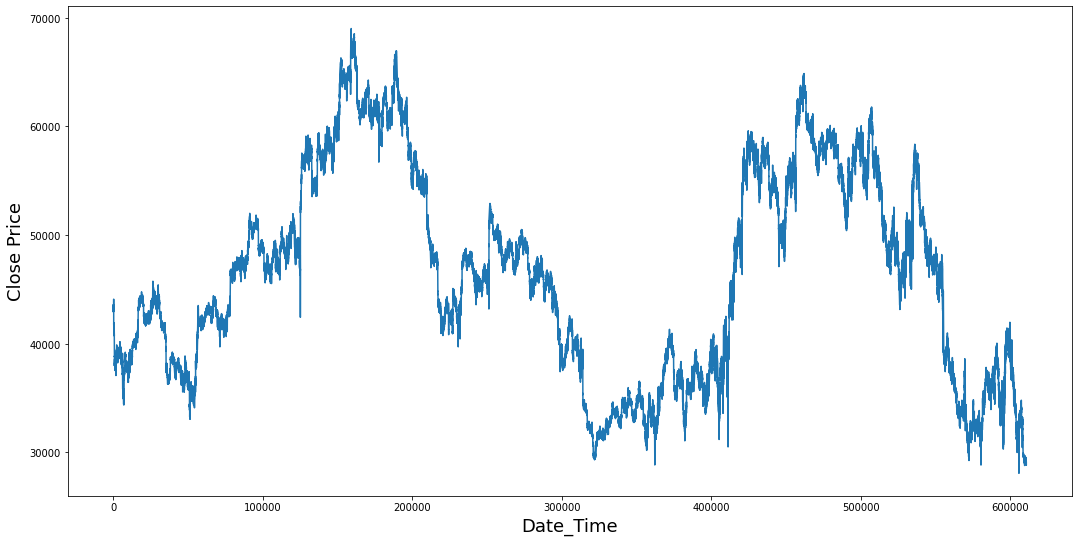

In [125]:
# Plot le cours du Bitcoin sur 5 ans
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['close']))
plt.xlabel('Date_Time',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [128]:
SEQ_LEN = 60 # On envoie une séquence de 60 minutes
FUTURE_PERIOD = 10 # On prédit pour dans 10 mins
RATIO_TO_PREDICT = "close"	


In [129]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

On sépare les données en 3 paquets : 10% Test, 20% Validation, 70% pour l'entraînement.

In [130]:
times = sorted(df.index.values)  # get the times
last_10 = sorted(df.index.values)[-int(0.1*len(times))] 
last_20 = sorted(df.index.values)[-int(0.2*len(times))]

test_df = df[(df.index >= last_10)]
validation_df = df[(df.index >= last_20) & (df.index < last_10)]  
train_df = df[(df.index < last_20)] 

train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values

print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))

train shape (488626, 6)
valid shape (61078, 6)
test shape (61078, 6)


In [131]:
# On normalise les données entre 0 et 1
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [132]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

MinMaxScaler()

In [133]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [134]:
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.01
for ti in range(488626):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

In [135]:
def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [136]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)

In [137]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

In [138]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (488557, 60, 6)
valid shape (61009, 60, 6)
test shape (61009, 60, 6)


In [139]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 6))

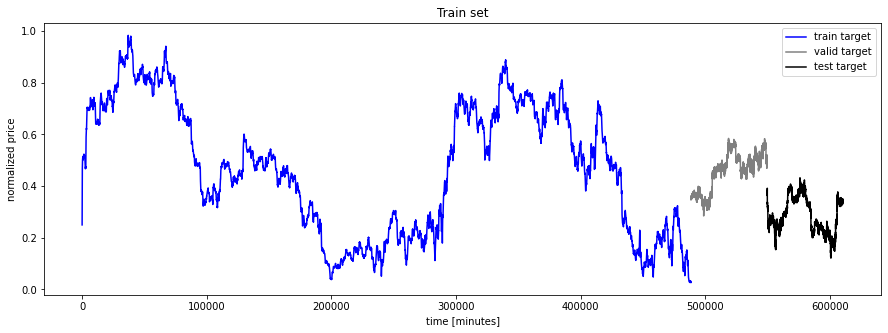

In [140]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Train set')
plt.xlabel('time [minutes]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# Transformers

In [141]:
# Shuffle des données
X_train, y_train = shuffle(X_train, y_train)

In [142]:
EPOCHS = 60
BATCH_SIZE = 256



### Construction du modèle

In [143]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

In [144]:
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

In [145]:
class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

In [146]:
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

    
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    
    
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

In [147]:
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

Text(0.5, 0, 'Train Step')

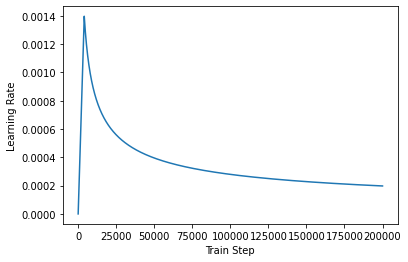

In [148]:
sample_learning_rate = CustomeLearningSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [149]:
D_MODEL=300

lr = CustomeLearningSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [158]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 6))

    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    #for i in range(2):
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512, 
            n_head=4, 
            d_k=64,
            d_v=64, 
            dropout=0.2)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = optimizer)
    
    return model

In [159]:
multi_head = build_model()
multi_head.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 60, 6)]      0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 60, 256)     138240      ['input_7[0][0]']                
 l)                                                                                               
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 60, 128)     164352      ['bidirectional_12[0][0]']       
 l)                                                                                               
                                                                                            

In [160]:
tf.keras.utils.plot_model(multi_head)

AttributeError: ignored

### Entraînement

In [161]:
callback = EarlyStopping(monitor='val_loss',
                         patience=3,
                         restore_best_weights=True)

In [162]:
history = multi_head.fit(x=X_train, 
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid), 
                         callbacks=[callback])

Epoch 1/60
1909/1909 [==============================] - 111s 55ms/step - loss: 0.0044 - val_loss: 8.4055e-04
Epoch 2/60
1909/1909 [==============================] - 104s 54ms/step - loss: 1.3739e-04 - val_loss: 0.0328
Epoch 3/60
1909/1909 [==============================] - 104s 54ms/step - loss: 7.0885e-05 - val_loss: 0.0297
Epoch 4/60
1909/1909 [==============================] - 104s 54ms/step - loss: 3.9389e-05 - val_loss: 0.0098


In [163]:
 multi_head.load_weights('./checkpoints/final_checkpoint_1')


NotFoundError: ignored

### Test

In [164]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)


predicted_stock_price_multi_head.shape

(61009, 1)

In [165]:
predicted_stock_price = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

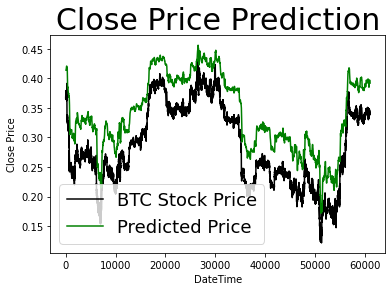

In [166]:
plt.plot(y_test, color = 'black', label = 'BTC Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()